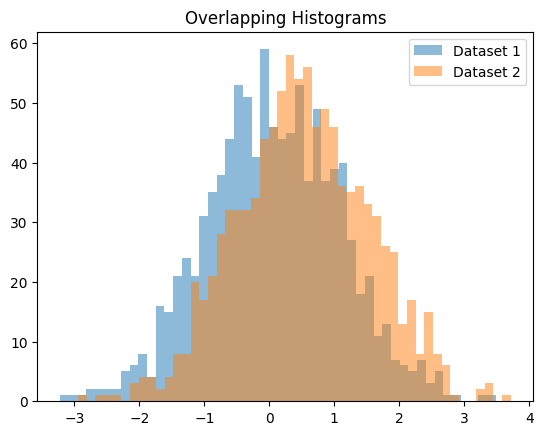

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image
# Sample data
data1 = np.random.normal(0, 1, 1000)
data2 = np.random.normal(0.5, 1, 1000)

plt.hist(data1, bins=50, alpha=0.5, label='Dataset 1')
plt.hist(data2, bins=50, alpha=0.5, label='Dataset 2')

plt.legend()
plt.title("Overlapping Histograms")
plt.show()


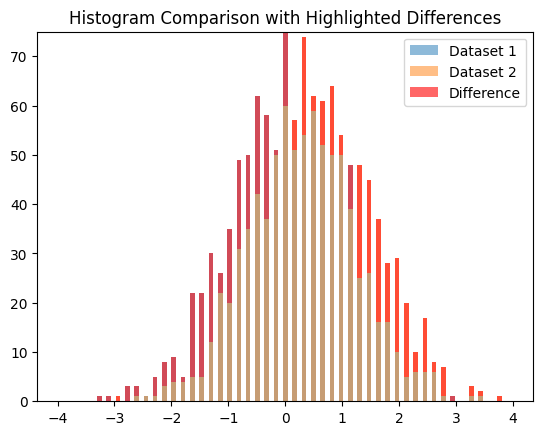

In [14]:
# Compute histograms
bins = np.linspace(-4, 4, 50)
hist1, _ = np.histogram(data1, bins=bins)
hist2, _ = np.histogram(data2, bins=bins)

# Centers of bins for plotting
bin_centers = 0.5 * (bins[1:] + bins[:-1])
diff = hist2 - hist1

# Plot both histograms
plt.bar(bin_centers, hist1, width=0.08, alpha=0.5, label='Dataset 1')
plt.bar(bin_centers, hist2, width=0.08, alpha=0.5, label='Dataset 2')

# Plot the difference
plt.bar(bin_centers, diff, width=0.08, color='red', alpha=0.6, label='Difference', bottom=hist1)

plt.legend()
plt.title("Histogram Comparison with Highlighted Differences")
plt.show()


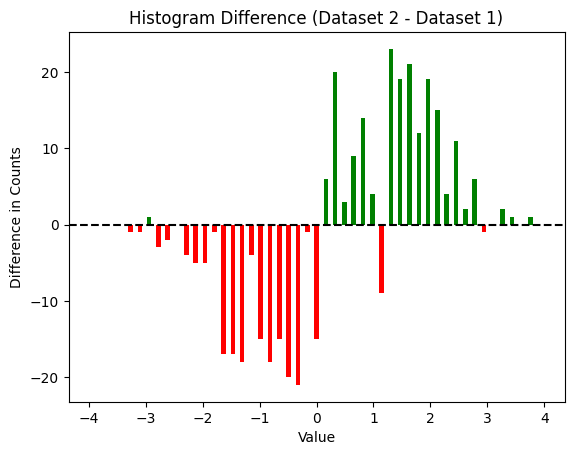

In [15]:
plt.bar(bin_centers, diff, width=0.08, color=np.where(diff > 0, 'green', 'red'))
plt.axhline(0, color='black', linestyle='--')
plt.title("Histogram Difference (Dataset 2 - Dataset 1)")
plt.xlabel("Value")
plt.ylabel("Difference in Counts")
plt.show()


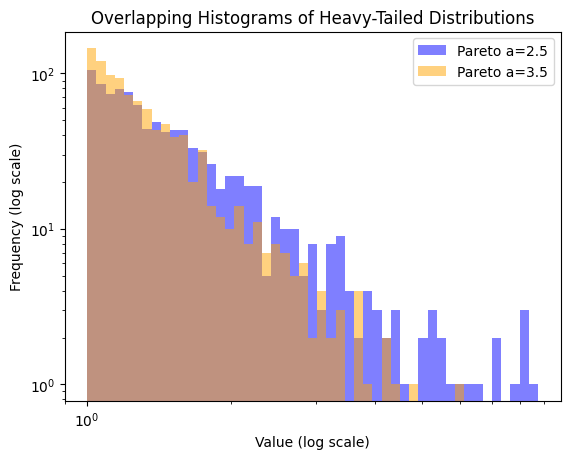

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Generate heavy-tailed data using Pareto distribution
# Pareto with shape parameter a (lower a = heavier tail)
data1 = (np.random.pareto(a=2.5, size=1000) + 1)  # Shift so min=1
data2 = (np.random.pareto(a=3.5, size=1000) + 1)  # Less heavy tail

# Use logarithmic bins to better display heavy tails
bins = np.logspace(np.log10(1), np.log10(np.max([data1.max(), data2.max()])), 50)

plt.hist(data1, bins=bins, alpha=0.5, label='Pareto a=2.5', color='blue')
plt.hist(data2, bins=bins, alpha=0.5, label='Pareto a=3.5', color='orange')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Overlapping Histograms of Heavy-Tailed Distributions')
plt.legend()
plt.show()



In [33]:
def plot_histogram(rain_pixel_values, sampled_pixel_values):
    # Define bins (log spaced)
    bins = np.logspace(
        np.log10(1),
        np.log10(np.max([rain_pixel_values.max(), sampled_pixel_values.max()])),
        50
    )

    # Compute histograms for both datasets
    hist1, _ = np.histogram(rain_pixel_values, bins=bins)
    hist2, _ = np.histogram(sampled_pixel_values, bins=bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    diff = hist2 - hist1

    # Create 2 subplots vertically aligned with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]})

    # Top plot: overlapping histograms
    ax1.hist(rain_pixel_values, bins=bins, alpha=0.6, label='target rain', color='green')
    ax1.hist(sampled_pixel_values, bins=bins, alpha=0.6, label='sampled rain', color='blue')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_ylabel("Frequency")
    ax1.set_title("Rain VS Sampled Rain Pixel Values")
    ax1.legend()

    # Bottom plot: difference bar plot
    ax2.bar(bin_centers, diff, width=np.diff(bins), color=np.where(diff > 0, 'green', 'red'), align='center')
    ax2.axhline(0, color='black', linestyle='--')
    ax2.set_xscale('log')
    ax2.set_xlabel("Pixel Value")
    ax2.set_ylabel("Difference")
    ax2.set_title("Histogram Difference (Sampled - Target)")

    plt.tight_layout()

    # Save to in-memory buffer before plt.show()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    image = Image.open(buf)
    plt.close(fig)  # Release memory

    return np.array(image)


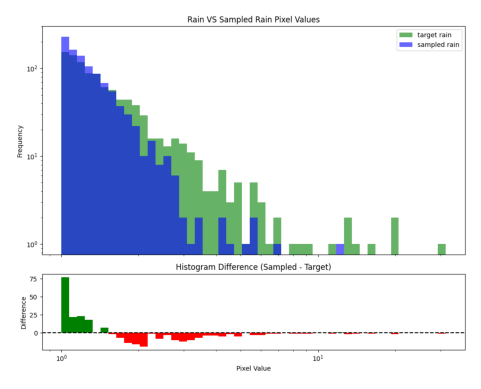

In [34]:
image = plot_histogram(np.random.pareto(a=2.5, size=1000) + 1, np.random.pareto(a=3.5, size=1000) + 1)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


In [2]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
def plot_range_metrics(range_metrics, key="RainDiffusion_eval_range_metrics", to_wandb=True, png_path=None):
    """
    Log range metrics (nested dict) to wandb as a table and optionally save as PNG.

    Parameters:
        range_metrics: dict[str, dict[str, float]]
        key: name for the table in wandb
        to_wandb: whether to log the table to Weights & Biases
        png_path: optional file path to save the table as a PNG image
    """
    # Get all unique metric names across all rain types
    all_metrics = sorted({metric for m in range_metrics.values() for metric in m.keys()})
    
    # Create DataFrame
    df = pd.DataFrame.from_dict(range_metrics, orient="index")
    df = df.reindex(columns=all_metrics)  # Ensure consistent column order
    df.index.name = "rain_type"
    df.reset_index(inplace=True)  # Make 'rain_type' a column

    if to_wandb:
        # Define columns and create wandb Table
        columns = df.columns.tolist()
        table = wandb.Table(columns=columns)
        for _, row in df.iterrows():
            table.add_data(*row.values.tolist())
        wandb.log({key: table})

    if png_path:
        # Plot DataFrame as a table using matplotlib
        fig, ax = plt.subplots(figsize=(1.5 * len(df.columns), 0.5 * len(df) + 1))
        ax.axis("off")
        mpl_table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(10)
        mpl_table.scale(1.2, 1.2)  # Adjust cell scaling

        plt.tight_layout()
        plt.savefig(png_path, dpi=300)
        plt.close(fig)

            

In [3]:
range_metrics = {
    "rain_type_1": {"metric_1": 0.8, "metric_2": 0.6},
    "rain_type_2": {"metric_1": 0.7, "metric_2": 0.5},
    "rain_type_3": {"metric_1": 0.9, "metric_2": 0.4}
}
plot_range_metrics(range_metrics, key="RainDiffusion_eval_range_metrics", to_wandb=False, png_path="range_metrics.png")

In [4]:
import torch.nn.functional as F

import numpy as np

def get_log_intervals(n, num_points=10):
    """
    Returns a sorted list of unique, integer log-distributed timesteps from 0 to n.
    
    Args:
        n (int): Maximum timestep.
        num_points (int): Number of log steps (more means finer spacing).

    Returns:
        List[int]: Log-distributed time steps.
    """
    # Avoid log(0) by starting from 1
    log_steps = np.logspace(start=0, stop=np.log10(n), num=num_points, dtype=int)
    unique_steps = sorted(set(log_steps))
    
    # Ensure 0 and n are included
    if 0 not in unique_steps:
        unique_steps = [0] + unique_steps
    
    return unique_steps

print(get_log_intervals(500,12))

[0, 1, 3, 5, 9, 16, 29, 52, 91, 161, 284, 499]


In [6]:
def loss_per_timesteps(timesteps):
    log_values = get_log_intervals(timesteps, 10)
    dict_timesteps_loss = {
        f"{log_values[t]}-{log_values[t+1]}" : 0 for t in range(len(log_values) - 1)
    }
    return dict_timesteps_loss

print(loss_per_timesteps(500))



{'0-1': 0, '1-3': 0, '3-7': 0, '7-15': 0, '15-31': 0, '31-62': 0, '62-125': 0, '125-250': 0, '250-499': 0}


In [ ]:
# File path to base NetCDF data
file_path = './grid_france_1536-1km_200906110000-219912310000.nc'

# Open the NetCDF file
with Dataset(file_path) as dataset:
    latitude = dataset.variables['latitude'][:]  
    longitude = dataset.variables['longitude'][:]  
